In [1]:
import pandas as pd
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression, LinearRegression
from imblearn.ensemble import BalancedRandomForestClassifier
import scikitplot as skplt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

raw_file = pd.read_csv("Apply_Rate_2019.csv")
pd.options.display.float_format = '{:.2f}'.format
raw_file.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,class_id
count,948319.00,948319.00,1200890.00,1200890.00,1200890.00,944335.00,1200890.00,1200890.00,1200890.00
mean,5.89,0.10,1.77,0.02,0.04,0.56,10.10,0.09,-395626280864141760.00
std,9.75,0.28,2.24,0.01,0.05,0.50,17.39,0.29,5664017325466159104.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-9049387715076603904.00
25%,0.00,0.00,0.00,0.01,0.01,0.00,2.00,0.00,-4593390417958236672.00
50%,0.00,0.00,0.25,0.02,0.02,1.00,6.00,0.00,-1614082818015232512.00
75%,11.64,0.06,3.42,0.02,0.04,1.00,14.00,0.00,4315422483091001344.00
max,93.52,7.30,17.74,0.26,1.29,1.00,1340.00,1.00,9204124302215888896.00


## REMOVE DUPLICATES

We start off by removing exact duplicate records from our dataset

In [2]:
# removing duplicate records
prev_shape = raw_file.shape[0]
df = raw_file.drop_duplicates()
print('Rows dropped: ', prev_shape - df.shape[0])

Rows dropped:  86131


## REMOVING MULTIPLES SCANS OF SAME JOB 

It's worht noting that some jobs were visited multiple times with exact query match and location match etc. but not applied. I suspect that that the same user had searched the jobs but came back later to apply the same job. Thus, for such scenarios where all feature variables are same but the apply column, I removed the entried with 0 and kep the ones.

In [3]:
# removing records where the job was searched multiple times and eventually applied and hence keeping only 1 record
prev_size = df.shape[0]

# Skip columns from the duplicacy check
columns = df.columns.difference(['apply', 'city_match', 'class_id'])
dup_rows = df[df.duplicated(subset=columns, keep=False)]
# Determine indices to drop
indices_to_drop = dup_rows[dup_rows['apply'] == 0].index.values
# Drop duplicate with indices
df_no_dup = df.drop(indices_to_drop, axis=0)

print(prev_size - df_no_dup.shape[0], ' rows dropped')

150286  rows dropped


## CORRELATION

We plot the correlation after prelimary lceaning of data sets to see the correlation of our features and target. 

As can be seen from the matrix, the correlation is not adequate for any model to infer much meaning.

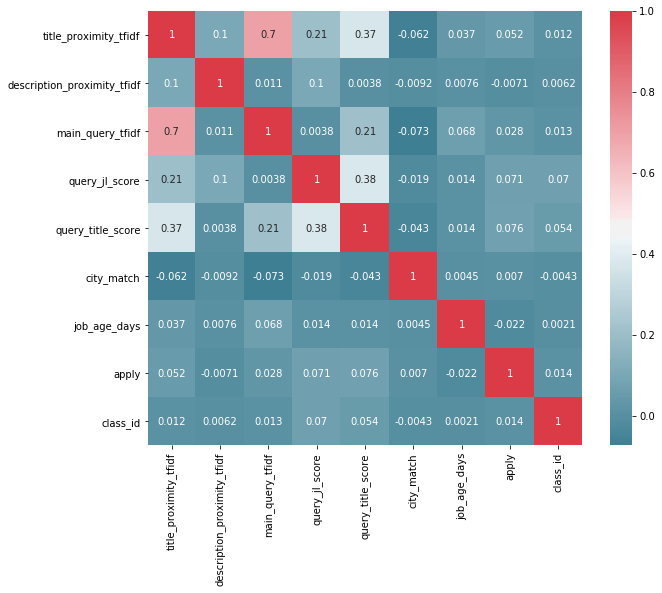

In [4]:
# correlation after prelimary cleaning
# plotting the correlation matrix

f, ax = plt.subplots(figsize=(10, 8))
corr = df_no_dup.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## IMPUTING MISSING CELLS
We also note the outlier in job age days, and try to figure out how the job age relates to positive and negative clases. 
Turns out there are a lot of candidates who have apppied jobs older than 6 months
Hence I decide to consider this feature even though it has a negative correlation with our target

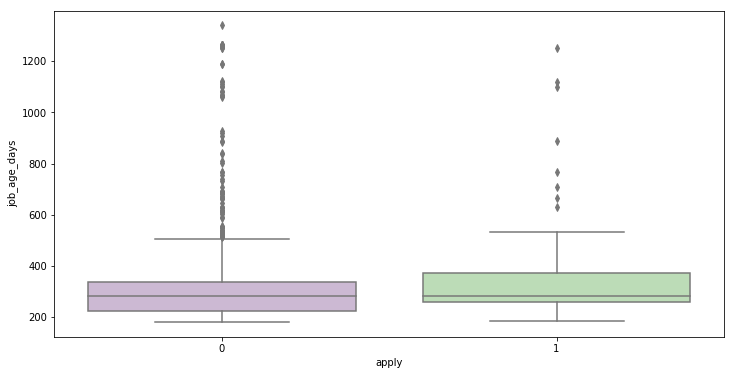

In [5]:
data2=df[df['job_age_days']>180]
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x="apply", y="job_age_days", data=data2, palette="PRGn")

In [6]:
# seeign the null cells in our features
df_no_dup.isnull().sum()

title_proximity_tfidf          169295
description_proximity_tfidf    169295
main_query_tfidf                    0
query_jl_score                      0
query_title_score                   0
city_match                     214524
job_age_days                        0
apply                               0
search_date_pacific                 0
class_id                            0
dtype: int64

## IMPUTING MISSING VALUES

Here we handle the missing values and drop the description proximity feature due to it's negative correlation

In [7]:
# plugging in missing values
def impute_missing_values(t_col, f_cols, model):
    train_x = df_no_dup.loc[df_no_dup[t_col].notnull(), f_cols]
    train_y = df_no_dup.loc[df_no_dup[t_col].notnull(), t_col]
    predict_x = df_no_dup.loc[df_no_dup[t_col].isnull(), f_cols]
    mod = model.fit(train_x, train_y)
    df_no_dup.loc[df_no_dup[t_col].isnull(), t_col] = mod.predict(predict_x)

# imputing title proximity null values with the mean value
df_no_dup['title_proximity_tfidf'].fillna(df_no_dup['title_proximity_tfidf'].mean(), inplace=True)
    
# dropping description proximity feature
df_no_dup.drop('description_proximity_tfidf', axis = 1, inplace=True)

# imputing values using logistic regression in city_match
impute_missing_values( 'city_match', ['apply', 'job_age_days', 'main_query_tfidf'], LogisticRegression())


c:\program files\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## CORREALTION OF PREPARED DATASET

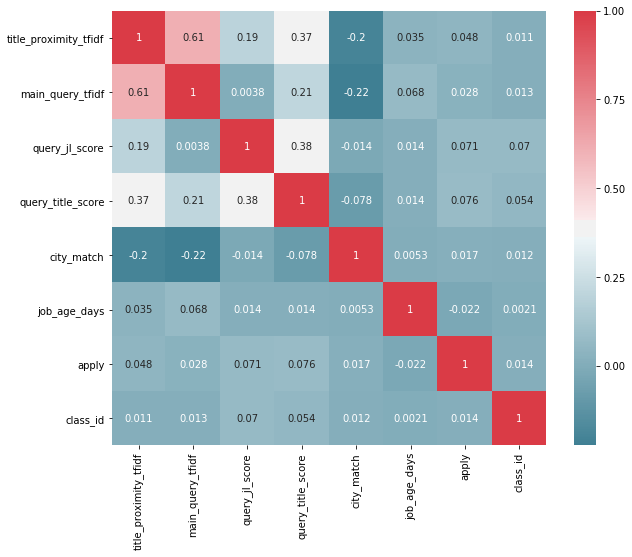

In [8]:
# plotting the correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = df_no_dup.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot = True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## CREATE DATA SETS -- TRAIN AND TEST FEATURES

Now we create our dataset, dividing train and test set on the basis of apply date and further into features and target

In [9]:
# now dividing into test and train dataset
def create_dataset(df_no_dup, t_col, f_col):

    df_no_dup['search_date_pacific'] = pd.to_datetime(df_no_dup['search_date_pacific'])
    train, test = df_no_dup[df_no_dup['search_date_pacific'] < '27-01-2018'], df_no_dup[df_no_dup['search_date_pacific'] == '27-01-2018']

    # df_1 = train.loc[train['apply'] == 1]
    # df_0 = train.loc[train['apply'] == 0]
    # df_0 = df_0.sample(frac=1/3, replace=True, random_state=1)
    # df_1 = df_1.sample(frac=1, replace=True, random_state=1)
    # df_0.groupby('apply').count()
    # df_1.groupby('apply').count()
    # train = pd.concat([df_0, df_1])

    features = train.loc[:,f_col]
    # features = train.loc[:,'main_query_tfidf':'job_age_days']
    target = train.loc[:, t_col]
    x_train, y_train = np.asarray(features), np.asarray(target)

    features_test = test.loc[:,f_col]
    # features_test = test.loc[:,'main_query_tfidf':'job_age_days']
    target_test = test.loc[:, t_col]
    x_test, y_test = np.asarray(features_test), np.asarray(target_test)
    
    return [train, test, x_train, y_train, x_test, y_test]

train, test, x_train, y_train, x_test, y_test = create_dataset(
    df_no_dup, 'apply', 
    ['title_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score', 'city_match', 'job_age_days'])

In [10]:
# let' see our distribution now
train.groupby('apply').count()

,title_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,search_date_pacific,class_id
apply,,,,,,,,
0,780323,780323,780323,780323,780323,780323,780323,780323
1,89833,89833,89833,89833,89833,89833,89833,89833


## BALANCED CALSSIFIER

We train using a balanced random forest classifier using a 5 fold croos validator

In [11]:
# doing balanced random forest fit now
brf = BalancedRandomForestClassifier(n_estimators=100, criterion='gini')

param_grid = [{}]

grid = GridSearchCV(brf, param_grid,
                           cv=StratifiedKFold(n_splits=5,
                                              random_state=42).split(x_train, y_train),
                           verbose=2)

grid.fit(x_train, y_train)
y_pred = grid.predict(x_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.3min finished


## PLOTTING FUNCTION

A plotting function is defined to plot confusion matrix and heatmap of our models perfomance

Balanced accuracy is:  0.5708517761916723
              precision    recall  f1-score   support

           0       0.92      0.59      0.72     84496
           1       0.14      0.55      0.22      9821

   micro avg       0.58      0.58      0.58     94317
   macro avg       0.53      0.57      0.47     94317
weighted avg       0.84      0.58      0.67     94317



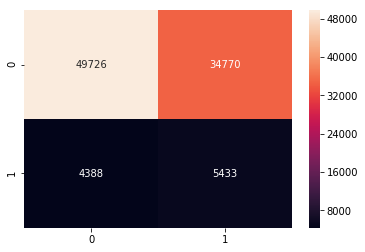

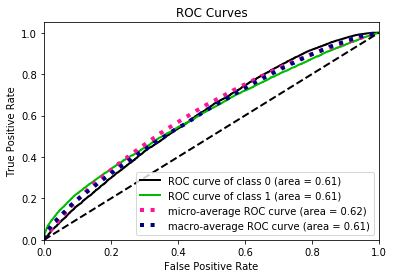

In [12]:
def plot_results(model, y_test, x_test, y_pred):
    print('Balanced accuracy is: ', balanced_accuracy_score(y_test, y_pred))
    report = classification_report(y_test, y_pred)
    print(report)

    # plotting heatmap
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='0.0f')
    
    # plotting roc curve
    y_pred_probab = grid.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test, y_pred_probab)
    plt.show()
    
plot_results(grid, y_test, x_test, y_pred)

## RANDOM FOREST WITH CUSTOM WEIGHTS

After a balanced random forest, we try the same with custom weights and some more parameters optimized:

Balanced accuracy is:  0.5877084842829807
              precision    recall  f1-score   support

           0       0.92      0.60      0.73     84496
           1       0.14      0.57      0.23      9821

   micro avg       0.60      0.60      0.60     94317
   macro avg       0.53      0.59      0.48     94317
weighted avg       0.84      0.60      0.68     94317



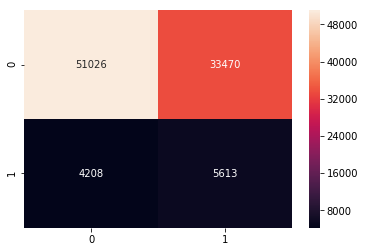

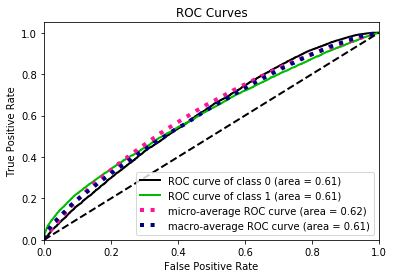

In [13]:
# trying with random forest with actual weights of the training model 
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train.flatten())

w_dct = {0:weights[0], 1: weights[1]}


model = RandomForestClassifier(bootstrap=True,

            class_weight=w_dct, 
            criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=42,
            verbose=0, warm_start=False)

param_grid = [{}]

# grid_search = GridSearchCV(rbf, param_grid,
#                            cv=StratifiedKFold(n_splits=5,
#                                               random_state=42).split(x_train, y_train),
#                            verbose=2)

model = model.fit(x_train, y_train)
y_preds = model.predict(x_test)
# LET'S PLOT THE RESULTS FOR ABOVE MODEL
plot_results(model, y_test, x_test, y_preds)

## WITH CLASS_ID INVOLVED

Utilizing the class_id feature I decide to cluster the model into 3 cluster to better sample my train and test examples.

In [14]:
# Create Clusters of data using K-Means Clustering (3 Clusters)
n_clusters = 3
# changing all class_ids to postive numbers
train[['class_id']] = abs(train[['class_id']])
test[['class_id']] = abs(test[['class_id']])

# train_class_id
kmc = KMeans(n_clusters=n_clusters).fit(train[['class_id']])
test_labels = kmc.predict(test[['class_id']])

c:\program files\python36\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


## RUNNING THE FOREST MODEL FOR ALL THREE CLUSTERS

After creating 3 cluster based on class id, we now move to sample our training and test data accordingly and subsequently run the Random forest classifier with custom weights on each of the cluster:

Balanced accuracy is:  0.6019337493752899
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     33238
           1       0.17      0.54      0.26      4286

   micro avg       0.65      0.65      0.65     37524
   macro avg       0.54      0.60      0.51     37524
weighted avg       0.83      0.65      0.71     37524



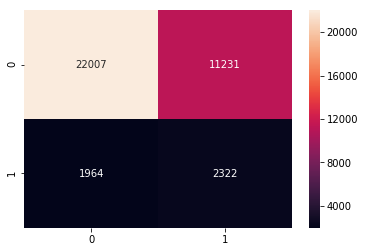

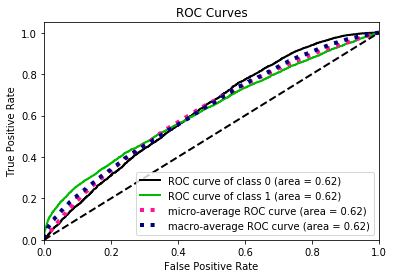

Balanced accuracy is:  0.570866084688666
              precision    recall  f1-score   support

           0       0.93      0.55      0.69     21795
           1       0.12      0.59      0.20      2280

   micro avg       0.55      0.55      0.55     24075
   macro avg       0.52      0.57      0.45     24075
weighted avg       0.85      0.55      0.64     24075



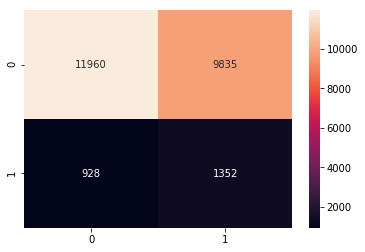

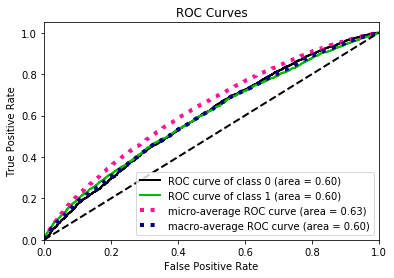

Balanced accuracy is:  0.5803944367621281
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     29463
           1       0.14      0.54      0.22      3255

   micro avg       0.61      0.61      0.61     32718
   macro avg       0.53      0.58      0.48     32718
weighted avg       0.85      0.61      0.69     32718



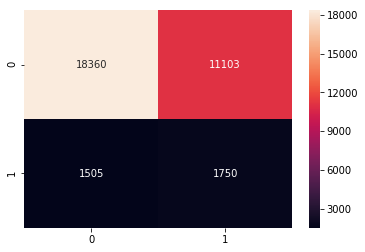

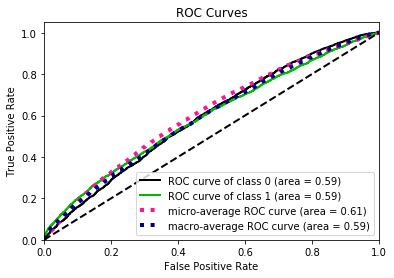

In [15]:
unnecessary_cols = ['apply', 'search_date_pacific', 'class_id']


model = RandomForestClassifier(bootstrap=True, class_weight='balanced', 
            criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300,
            oob_score=False,
            random_state=42,
            verbose=0, warm_start=False)

for i in range(n_clusters):    
    train_indexes = np.where(kmc.labels_ == i)[0]
    test_indexes = np.where(test_labels == i)[0]
    
    train_set = train.iloc[train_indexes]
    # Remove attributes not required by the model
    train_x = train_set.drop(unnecessary_cols, axis=1).reset_index(drop=True)
    train_y = train_set.loc[:, 'apply'].reset_index(drop=True)
    
    test_x = test.iloc[test_indexes].drop(unnecessary_cols, axis=1).reset_index(drop=True)
    test_y = test.iloc[test_indexes, -3].reset_index(drop=True)
    
    model.fit(train_x, train_y)
    
    y_preds = model.predict(test_x)
    plot_results(model, test_y, test_x, y_preds)